# Sequence-to-Sequence Abstracter: Card Sorting

## Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import sklearn.metrics
from sklearn.model_selection import train_test_split
import utils
import seq2seq_transformer
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder


In [2]:
#%env "WANDB_NOTEBOOK_NAME" "abstractor_SCAN.ipynb"
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: john-lafferty (wu-tsai-institute). Use `wandb login --relogin` to force relogin


True

In [3]:
def create_callbacks(monitor='loss'):
    callbacks = [wandb.keras.WandbMetricsLogger(log_freq='epoch'),]
    return callbacks

## Dataset

In [2]:

import urllib.request 
from collections import Counter
data_url = 'https://raw.githubusercontent.com/brendenlake/SCAN/master/tasks.txt'
data = urllib.request.urlopen(data_url)

input_voc = Counter()
input_voc.update(['<pad>'])
output_voc = Counter()
output_voc.update(['<PAD>'])
input_len = output_len = input_max = output_max = 0

records=0
for line in data: 
    command = line.decode("utf-8") 
    _, input, output = command.replace('OUT:', 'IN:').split('IN:')
    input_voc.update(input.split())
    output_voc.update(output.split())
    input_max = max([input_max, len(input.split())])
    output_max = max([output_max, len(output.split())])
    input_len = input_len + len(input.split())
    output_len = output_len + len(output.split())
    records = records + 1

print('Number of records: %d' % records)
print('Maximum lengths: %d, %d' % (input_max, output_max))
print('Average lengths: %.2f, %.2f' % (input_len/records, output_len/records))
print(input_voc)
print(output_voc)

words = [w for w in input_voc]
commands = [c for c in output_voc]
word2index = {words[i]:i for i in range(len(words))}
command2index = {commands[i]:i for i in range(len(commands))}

print('Input vocabulary size: %d' % len(words))
print(words)
print('Output vocabulary size: %d' % len(commands))
print(commands)



Number of records: 20910
Maximum lengths: 9, 48
Average lengths: 7.25, 14.32
Counter({'right': 18405, 'left': 18405, 'thrice': 13906, 'twice': 13906, 'opposite': 12270, 'around': 12270, 'after': 10404, 'and': 10404, 'walk': 8589, 'run': 8589, 'look': 8589, 'jump': 8589, 'turn': 7362, '<pad>': 1})
Counter({'I_TURN_RIGHT': 85890, 'I_TURN_LEFT': 85890, 'I_RUN': 31902, 'I_WALK': 31902, 'I_LOOK': 31902, 'I_JUMP': 31902, '<PAD>': 1})
Input vocabulary size: 14
['<pad>', 'walk', 'opposite', 'right', 'thrice', 'after', 'run', 'turn', 'around', 'twice', 'look', 'left', 'and', 'jump']
Output vocabulary size: 7
['<PAD>', 'I_TURN_RIGHT', 'I_RUN', 'I_WALK', 'I_TURN_LEFT', 'I_LOOK', 'I_JUMP']


In [3]:

data_url = 'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_train_addprim_jump.txt'
data = urllib.request.urlopen(data_url)

n = records
length_max = 30

BEGIN_INPUT = len(input_voc) # token for 'beginning of input'
END_INPUT = len(input_voc)+1 # token for 'end of input'
BEGIN_COMMAND = len(output_voc) # token for 'beginning of command'
END_COMMAND = len(output_voc)+1 # token for 'end of command'

sources = np.array(n*(length_max+2)*[0]).reshape(n, length_max+2)
targets = np.array(n*(length_max+2)*[0]).reshape(n, length_max+2)
data = urllib.request.urlopen(data_url)

rec = 0
longones = 0
for line in data: 
    command = line.decode("utf-8") 
    _, input, output = command.replace('OUT:', 'IN:').split('IN:')
    input_words = input.split()
    output_commands = output.split()
    source = [word2index[w] for w in input_words]
    source.insert(0, BEGIN_INPUT)
    source.append(END_INPUT)
    target = [command2index[c] for c in output_commands]
    if len(target) > length_max:
        longones = longones + 1
        continue
    target.insert(0, BEGIN_COMMAND)
    target.append(END_COMMAND)
    for j in range(len(source)):
        sources[rec, j] = source[j]
    for j in range(len(target)):
        targets[rec, j] = target[j]
    rec = rec + 1

print('processed %d commands' % rec)
print('processed %d (%.2f%%) over length %d' % (longones, 100*longones/(rec+longones), length_max))

sources_train = sources[:rec,:]
targets_train = targets[:rec,:]


processed 13998 commands
processed 672 (4.58%) over length 30


In [4]:
data_url = 'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_test_addprim_jump.txt'
data = urllib.request.urlopen(data_url)

n = records
length_max = 30

BEGIN_INPUT = len(input_voc) # token for 'beginning of input'
END_INPUT = len(input_voc)+1 # token for 'end of input'
BEGIN_COMMAND = len(output_voc) # token for 'beginning of command'
END_COMMAND = len(output_voc)+1 # token for 'end of command'

sources = np.array(n*(length_max+2)*[0]).reshape(n, length_max+2)
targets = np.array(n*(length_max+2)*[0]).reshape(n, length_max+2)
data = urllib.request.urlopen(data_url)

rec = 0
longones = 0
for line in data: 
    command = line.decode("utf-8") 
    _, input, output = command.replace('OUT:', 'IN:').split('IN:')
    input_words = input.split()
    output_commands = output.split()
    source = [word2index[w] for w in input_words]
    source.insert(0, BEGIN_INPUT)
    source.append(END_INPUT)
    target = [command2index[c] for c in output_commands]
    if len(target) > length_max:
        longones = longones + 1
        continue
    target.insert(0, BEGIN_COMMAND)
    target.append(END_COMMAND)
    for j in range(len(source)):
        sources[rec, j] = source[j]
    for j in range(len(target)):
        targets[rec, j] = target[j]
    rec = rec + 1

print('processed %d commands' % rec)
print('processed %d (%.2f%%) over length %d' % (longones, 100*longones/(rec+longones), length_max))

sources_test = sources[:rec,:]
targets_test = targets[:rec,:]


processed 7226 commands
processed 480 (6.23%) over length 30


In [5]:
def display_sentence(input_seq):
    sentence = ''
    for i in range(len(input_seq)):
        if input_seq[i] == BEGIN_INPUT:
            sentence = sentence + 'BEGIN_INPUT'
        elif input_seq[i] == END_INPUT:
            sentence = sentence + ' END_INPUT'
            break
        else: 
            sentence = sentence + ' ' + words[input_seq[i]]
    return sentence

def display_command(output_seq):
    command = ''
    for i in range(len(output_seq)):
        if output_seq[i] == BEGIN_COMMAND:
            command = command + 'BEGIN_COMMAND'
        elif output_seq[i] == END_COMMAND:
            command = command + ' END_COMMAND'
            break
        else: 
            command = command + ' ' + commands[output_seq[i]]
    return command



In [6]:
print(display_sentence(sources_test[42,]))
print(display_command(targets_test[42,]))
print(sources_test[42,])
print(targets_test[42,])

BEGIN_INPUT jump opposite right thrice and walk opposite right thrice END_INPUT
BEGIN_COMMAND I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK END_COMMAND
[14 13  2  3  4 12  1  2  3  4 15  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[7 1 1 6 1 1 6 1 1 6 1 1 3 1 1 3 1 1 3 8 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
source_train = sources_train[:,:-1]
target_train = targets_train[:,:-1]
labels_train = targets_train[:,1:]

source_test = sources_test[:,:-1]
target_test = targets_test[:,:-1]
labels_test = targets_test[:,1:]


## Standard Transformer

In [10]:
from seq2seq_transformer import Encoder, AddPositionalEmbedding

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [11]:
transformer = Transformer(num_layers=2, num_heads=4, dff=64, 
    input_vocab_size=len(input_voc)+2, target_vocab_size=len(output_voc)+2, embedding_dim=64)

In [12]:
from seq2seq_transformer import masked_loss, masked_accuracy

transformer.compile(loss=masked_loss, optimizer=tf.keras.optimizers.Adam(), metrics=masked_accuracy)
transformer((source_train, target_train))

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 1024      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  149888    
                                                                 
 decoder (ContextDecoder)    multiple                  282880    
                                                       

In [13]:
wandb.init(project='Autoregressive Abstractors (SCAN)', group='std transformer')
history = transformer.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
219/219 [==============================] - 44s 162ms/step - loss: 0.9247 - masked_accuracy: 0.6452
Epoch 2/20
219/219 [==============================] - 36s 163ms/step - loss: 0.5278 - masked_accuracy: 0.7666
Epoch 3/20
219/219 [==============================] - 35s 161ms/step - loss: 0.3656 - masked_accuracy: 0.8353
Epoch 4/20
219/219 [==============================] - 35s 161ms/step - loss: 0.2325 - masked_accuracy: 0.8968
Epoch 5/20
219/219 [==============================] - 35s 160ms/step - loss: 0.1625 - masked_accuracy: 0.9331
Epoch 6/20
219/219 [==============================] - 35s 160ms/step - loss: 0.1174 - masked_accuracy: 0.9530
Epoch 7/20
219/219 [==============================] - 36s 162ms/step - loss: 0.0982 - masked_accuracy: 0.9605
Epoch 8/20
219/219 [==============================] - 36s 162ms/step - loss: 0.0762 - masked_accuracy: 0.9699
Epoch 9/20
219/219 [==============================] - 35s 162ms/step - loss: 0.0719 - masked_accuracy: 0.9719
Epoch 10/2

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▃▅▆▇▇▇█████████████
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.02605
epoch/masked_accuracy,0.99024


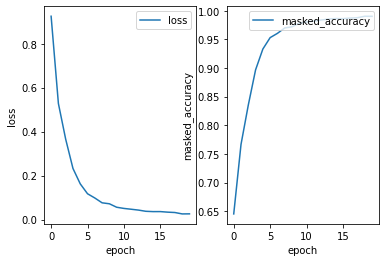

In [14]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [15]:

def evaluate_seq2seq_model(model, data):
    source_data, target_data, label_data = data
    n = 1000
    total_errors = 0
    total_predictions = 0
    for ind in range(n): #range(source_data.shape[0])):
        test_example = source_data[ind,:]
        output = 0*target_data[ind,:] 
        #output = np.zeros(len(target_data[ind,:])+1)
        output[0] = BEGIN_COMMAND
        #print(display_sentence(test_example))
        #print(display_command(target_data[ind]))
        #print(target_data[ind])
        for i in range(30):
            #print(output)
            predictions = model((test_example, output), training=False)
            predicted_id = tf.argmax(predictions[:, i, :], axis=-1)
            output[i+1] = predicted_id
            total_errors = total_errors + int(predicted_id != label_data[ind,i])
            total_predictions = total_predictions + 1
            if label_data[ind,i] == END_COMMAND:
                #print(output)
                #print(display_command(output))
                #print('')
                break
        if ind % 100 == 0:
            acc = (total_predictions-total_errors)/total_predictions
            print('per-token accuracy (%d examples, %d tokens): %.2f%%' % (ind, total_predictions, 100*acc))

    acc = (total_predictions-total_errors)/total_predictions
    print('per-token accuracy (%d examples, %d tokens): %.2f%%\n' % (n, total_predictions, 100*acc))
    return acc

In [16]:
#_ = evaluate_seq2seq_model(transformer, (source_train, target_train, labels_train));
_ = evaluate_seq2seq_model(transformer, (source_test, target_test, labels_test));

per-token accuracy (0 examples, 13 tokens): 84.62%
per-token accuracy (100 examples, 1401 tokens): 62.46%
per-token accuracy (200 examples, 2848 tokens): 63.66%
per-token accuracy (300 examples, 4347 tokens): 63.86%
per-token accuracy (400 examples, 5922 tokens): 63.81%
per-token accuracy (500 examples, 7418 tokens): 63.51%
per-token accuracy (600 examples, 8812 tokens): 63.92%
per-token accuracy (700 examples, 10301 tokens): 63.58%
per-token accuracy (800 examples, 11724 tokens): 63.78%
per-token accuracy (900 examples, 13186 tokens): 63.72%
per-token accuracy (1000 examples, 14486 tokens): 63.61%



### Abstractor with relational sensory-abstract cross-attention

- Encoder-Abstracter: Same as Episodic/Relational Abstracter above

- Decoder: Abstracter-Relations, Encoder-Values $(Q=A, K=A, V=E)$. I.e.: the sensory side (encoder and decoder) are connected via a skip connection

In [17]:
from seq2seq_transformer import EpisodicDecoder

class Seq2SeqSensoryConnectedAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_sensory_connected_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=abstracted_context, key_seq=abstracted_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [18]:
seq2seq_sensory_connected_abstracter = Seq2SeqSensoryConnectedAbstracter(num_layers=2, num_heads=4, dff=64,
    input_vocab_size=len(input_voc)+2, target_vocab_size=len(output_voc)+2, embedding_dim=64)


In [19]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=64)
seq2seq_sensory_connected_abstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
seq2seq_sensory_connected_abstracter((source_train, target_train))

seq2seq_sensory_connected_abstracter.summary()

Model: "seq2seq_sensory_connected_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 1024      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  149888    
                                                                 
 abstracter (EpisodicDecoder  multiple                 284864    
 )                            

In [20]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive sensory-connected abstracter')
history = seq2seq_sensory_connected_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
219/219 [==============================] - 69s 256ms/step - loss: 1.8867 - masked_accuracy: 0.3085
Epoch 2/20
219/219 [==============================] - 13762s 63s/step - loss: 1.0999 - masked_accuracy: 0.6019
Epoch 3/20
219/219 [==============================] - 66s 303ms/step - loss: 0.6989 - masked_accuracy: 0.7292
Epoch 4/20
219/219 [==============================] - 67s 304ms/step - loss: 0.5460 - masked_accuracy: 0.7814
Epoch 5/20
219/219 [==============================] - 69s 315ms/step - loss: 0.3329 - masked_accuracy: 0.8695
Epoch 6/20
219/219 [==============================] - 63s 289ms/step - loss: 0.2233 - masked_accuracy: 0.9119
Epoch 7/20
219/219 [==============================] - 58s 263ms/step - loss: 0.1647 - masked_accuracy: 0.9360
Epoch 8/20
219/219 [==============================] - 59s 267ms/step - loss: 0.1259 - masked_accuracy: 0.9517
Epoch 9/20
219/219 [==============================] - 58s 265ms/step - loss: 0.0990 - masked_accuracy: 0.9629
Epoch 10/

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇████
epoch/loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▄▅▆▇▇▇█████████████
epoch/epoch,19
epoch/learning_rate,0.00189
epoch/loss,0.04008
epoch/masked_accuracy,0.98611


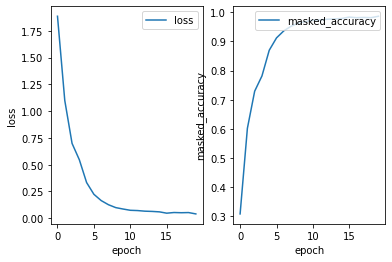

In [21]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [22]:
#_ = evaluate_seq2seq_model(seq2seq_sensory_connected_abstracter, (source_train, target_train, labels_train))
_ = evaluate_seq2seq_model(seq2seq_sensory_connected_abstracter, (source_test, target_test, labels_test))

per-token accuracy (0 examples, 13 tokens): 69.23%
per-token accuracy (100 examples, 1401 tokens): 61.74%
per-token accuracy (200 examples, 2848 tokens): 62.01%
per-token accuracy (300 examples, 4347 tokens): 62.99%
per-token accuracy (400 examples, 5922 tokens): 62.48%
per-token accuracy (500 examples, 7418 tokens): 61.66%
per-token accuracy (600 examples, 8812 tokens): 61.86%
per-token accuracy (700 examples, 10301 tokens): 62.37%
per-token accuracy (800 examples, 11724 tokens): 62.63%
per-token accuracy (900 examples, 13186 tokens): 62.60%
per-token accuracy (1000 examples, 14486 tokens): 62.63%



In [23]:
model = seq2seq_sensory_connected_abstracter
#model = transformer
source_data, target_data, label_data = (source_train, target_train, labels_train)
n = 1
start = 10
total_errors = 0
total_predictions = 0
for ind in np.arange(start,start+n): #source_test.shape[0]):
    test_example = source_data[ind,:]
    print(display_sentence(test_example))
    print(display_command(target_data[ind,:]))
    output = 0*target_data[ind,:]
    output[0] = BEGIN_COMMAND
    print(target_data[ind])
    for i in range(30):
        print(output)
        predictions = model((test_example, output), training=False)
        print(predictions[:, i, :])
        predicted_id = tf.argmax(predictions[:, i, :], axis=-1)
        output[i+1] = predicted_id
        total_errors = total_errors + int(predicted_id != label_data[ind,i])
        total_predictions = total_predictions + 1
        if predicted_id == END_COMMAND:
            print(output)
            print(display_command(output))
            break
acc = (total_predictions-total_errors)/total_predictions
print('per-token accuracy (%d examples, %d tokens): %.2f%%' % (n, total_predictions, 100*acc))


BEGIN_INPUT run left thrice and walk twice END_INPUT
BEGIN_COMMAND I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_WALK I_WALK END_COMMAND
[7 4 2 4 2 4 2 3 3 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tf.Tensor(
[[-2.2926412 -4.549774  -1.1293114 -1.570723  11.259981  -1.2857002
  -1.2380948 -1.949486  -3.0388896]], shape=(1, 9), dtype=float32)
[7 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tf.Tensor(
[[-1.6559632  -7.06736    11.002224    0.02962742  1.6074529   1.3182844
   0.156632   -0.7803637  -3.8115618 ]], shape=(1, 9), dtype=float32)
[7 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tf.Tensor(
[[-3.0107818 -3.5919511 -0.6870194 -3.0375216 11.283957  -3.661594
  -2.5817535 -2.4408212 -2.1432548]], shape=(1, 9), dtype=float32)
[7 4 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tf.Tensor(
[[-2.2118156  -4.511118   12.24274     0.06414397  1.1206284   0.7888204
  -0